In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize
from datetime import date
from datetime import datetime

In [87]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
ams_calls = amd_calls.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls


,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-14,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
2023-04-14,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2023-04-14,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
2023-04-14,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
2023-04-14,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


## First maturity

In [88]:
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [89]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [90]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

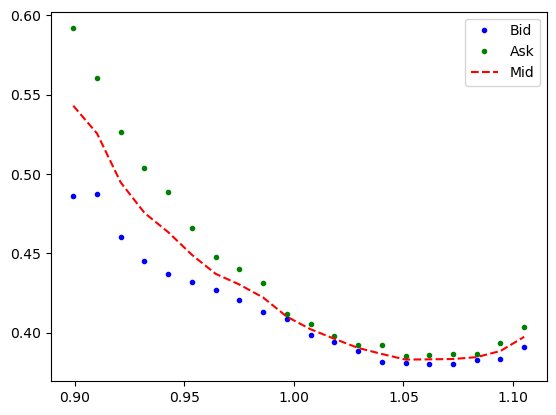

In [91]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


82.26725329153062


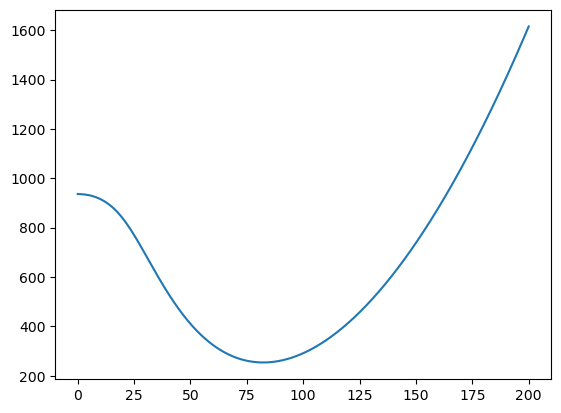

In [92]:
def sigma_objective(sigma,S0,delta_t):
    sqrtt = math.sqrt(delta_t)
    help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S0,delta_t):
    res = optimize.minimize_scalar(sigma_objective,args = (S0,delta_t))
    return res.x

sigma0 = calculate_sigma0(S0,6/252)
xx = np.linspace(0,200,1000)
f = lambda x: sigma_objective(x,S0,6/252)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma0)
P1 = lambda s1: 1


#def m_0(s,S0,sigma0,t1): # Joint distribution of S1 and S2
    #return (S0 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*S0))) * np.exp(-1/2*((s-S0)/(sigma0*S0))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*S0*np.sqrt(t1)) * np.exp(-1/2*((s-S0)/(sigma0*S0*np.sqrt(t1)))**2) )

def m0(s2,s1,delta_t,P1):
    '''
    m0: Joint distribution of (s1,s2)
    P1: Marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    sigma0 = calculate_sigma0(s1,delta_t)
    return norm.pdf(s2,s1,sigma0*np.sqrt(delta_t))/norm.cdf(s1/(sigma0*np.sqrt(delta_t))) * (s1 >= 0) * P1(s1)


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g
    




In [93]:
S0+3*sigma0

339.1017598745919

In [94]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  np.sqrt(2*np.pi)*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(np.sqrt(2))) - special.erf((A-alpha*sigma)/(np.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [95]:
def I_u_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)

def I_u(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1) )[0]

def I_u_(theta,V,K,s1,K1,K2,delta_t,P1): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*s1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI


# Check whether symbolic integration is correct
print(I_u(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_u(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_u_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_u_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


0.23189417511434798
0.024711207977887936
0.026016686496033503
0.02722176343418861
0.028306540260486374
0.029252540638539742
0.030043232272073162
0.03066450677706002
0.031105098149980984
0.03135692250086534
0.03141532474025603
0.03127922170305545
0.03095113556130621
0.03043711608590284
0.029746555104799184
0.02889190110788723
0.02788828611425339
0.026753080423155072
0.025505393536827233
0.02416554124707552
0.1407873715096764
----
0.9183936007554945
0.9183936007556585
---------
[0.9183936 0.9183936 0.9183936 0.9183936]


In [96]:
def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,K,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_h_0(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_h_0(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_h_0_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_h_0_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list



def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)*(s-s1)
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)*(s-s1)*(s-s1)

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


-3.872233618827188
-0.21734620096421148
-0.20282523574141822
-0.18501228594141733
-0.16409304877126624
-0.1403395974057791
-0.11410525567106722
-0.08581622581787687
-0.05596022808182871
-0.025072567777474207
0.006279816351738988
0.037515658928093276
0.06805729179355251
0.09734841273727471
0.12487093549423489
0.1501602081003594
0.1728179760709911
0.19252258897252356
0.20903609571929188
0.22220803582426407
1.8662590648912605
----
-1.9157281801156
-1.9157281801159414
---------
[-1.91572818 -1.91572818 -1.91572818 -1.91572818]


In [97]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

def I_Q_(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h0
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h0*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == numK-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_Q(0,np.zeros(numK),K,K[0],S0,K[i],K[i+1],6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,K[-1],110,6/252,P1))


print("---------")
print(I_Q_(np.zeros(4),np.zeros(numK),K,K[0],S0,0,110,6/252,P1)) # h0 can also be a list

print("----")
# Check for different Q's
print(I_Q_(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))



0.0
0.012468033230146263


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


0.03912994867169328
0.06815011399653668
0.09915777565125697
0.13170903053264046
0.1652968044592132
0.19936368720878123
0.2333171847129944
0.2665468114805733
0.29844233643612
0.32841242076650884
0.35590285251370024
0.380413592336171
0.40151389796886716
0.4188548884037106
0.43217903693354753
0.44132623690786565
0.4462362556117851
0.44694756942206637
3.1755816199312505
---------
[8.3409501 8.3409501 8.3409501 8.3409501]
----
16.164338591971816
16.164338594468763
8.340950097173941
8.340950095702324
6.395552698076312
6.395552698287572
0.5006215612473093
0.5006215612705092
0.05959040871900738
0.05959040817098695


In [98]:
def integrand_G1(s,V,u0,h0,K,omega,S0,delta_t,P1):
    return m0(s,S0,delta_t,P1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,delta_t,P1):
    #expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    expectation = I_u_(h0,V,K,S0,50,120,delta_t,P1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    #print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - I_Q_(h0,V,K,Q,S0,50,120,delta_t,P1)*np.exp(-u0) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad


def Hess_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Hessian of G_12
    '''
    H = np.zeros((numK,numK))
    H = np.diag(omega)
    
    for i in range(numK):
        for j in range(numK):
            integrand = lambda s: np.maximum((s-K[i]),0)*np.maximum((s-K[j]),0)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size)*m0(s,S0,sigma0,delta_t,P1)
            H[i,j] += integrate.quad(integrand,50,120)[0] 
    
    return H

    
    

In [99]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,delta_t,P1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,delta_t,P1)-G1(V,u0,h0,K,omega,S0,delta_t,P1))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

u1, h1, V = 0., 0., [0.]*numK
p0 = np.array([u1] + [h1] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,6/252,P1)




Grad = [-12.24856219 -12.05579364 -11.90093533 -11.71059301 -11.48647125
 -11.25536278 -10.99413482 -10.67971258 -10.33905986  -9.98415718
  -9.56697772  -9.09946136  -8.59348758  -8.04584768  -7.47321693
  -6.87212761  -6.2689433   -5.66983551  -5.08076296  -4.50745441]
Grad_FD = [-12.24853603 -12.05576962 -11.90091334 -11.71057293 -11.48645297
 -11.25534621 -10.99411985 -10.6796991  -10.33904777  -9.98414639
  -9.56696812  -9.09945288  -8.59348012  -8.04584114  -7.47321125
  -6.8721227   -6.26893909  -5.66983192  -5.08075993  -4.50745187]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


In [100]:
#def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    #'''
    #Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    #'''
    #Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    #u = np.ones(numK)
    #eps = 1e-7
    
    #Hess_u = Hess.dot(u)
    #Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    #print(f'Hess_u = {Hess_u}')
    #print(f'Hess_u_FD = {Hess_u_FD}')
    

#Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

In [101]:
u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252 #TODO: think about amount of trading days!
P1 = lambda s1: 1

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    #u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
    print(f' h0 = {h0}')
    u0 = np.log(I_u_(h0,V,K,S0,50,120,delta_t,P1))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")

    
    
    

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


 h0 = 0.00015547667682636748
 u0 = -0.015802117263645166
V = [ 0.12793555 -0.38983603  0.10092582  0.12566906 -0.13409752  0.002483
  0.2222723  -0.08106049 -0.22332374  0.22487393  0.09664189 -0.04107228
  0.0499256   0.00730088  0.13477382 -0.03969795  0.00839046  0.10246167
  0.08174401 -0.13055091]
normdiff = inf
----------
 h0 = 0.0021240603421269527
 u0 = 0.1079128260845013


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/673999581.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/673999581.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:


V = [ 0.11867086 -0.39628731  0.09803139  0.12553435 -0.13220033  0.00629354
  0.22752785 -0.07530271 -0.21721131  0.2316841   0.10332456 -0.03484247
  0.0556579   0.01225779  0.13907354 -0.03634218  0.01104422  0.10453209
  0.08324706 -0.12970516]
normdiff = 0.03328588714063254
----------
 h0 = 0.002579839429347511
 u0 = 0.11211419839660243
V = [ 0.07201771 -0.42400618  0.10363486  0.14843828 -0.10555716  0.03650127
  0.25583566 -0.06212323 -0.2157892   0.23517756  0.10045125 -0.04298283
  0.04720656  0.00193833  0.13126916 -0.0470655   0.00119962  0.09612652
  0.07446934 -0.14374821]
normdiff = 0.12555975865664654
----------
 h0 = 0.0030652433210951423
 u0 = 0.14037678463324052
V = [ 0.06954391 -0.42567212  0.10361981  0.14911424 -0.1047619   0.03748647
  0.25688799 -0.06145675 -0.21525169  0.23625836  0.10169857 -0.04158564
  0.04886352  0.00365047  0.13309709 -0.04547726  0.00264011  0.09739933
  0.07547676 -0.14317353]
normdiff = 0.0085076625524496
----------
 h0 = 0.0032038399571

In [102]:
c = np.zeros(numK)
for i in range(numK):
    c[i] = I_Q_(h0,V,K,K[i],S0,50,120,delta_t,P1)*np.exp(-u0)
    print(f'K={K[i]}, C = {c[i]}')

K=83.0, C = 9.682098923692289
K=84.0, C = 8.759159972864094
K=85.0, C = 7.849237717255231
K=86.0, C = 6.958595021179408
K=87.0, C = 6.095255471979563
K=88.0, C = 5.2668902879948405
K=89.0, C = 4.484851003145094
K=90.0, C = 3.7603973201734293
K=91.0, C = 3.0962577379579357
K=92.0, C = 2.4973082863622103
K=93.0, C = 1.9766491728365134
K=94.0, C = 1.5372120469408543
K=95.0, C = 1.1736550645684911
K=96.0, C = 0.8806941943582715
K=97.0, C = 0.651301911250852
K=98.0, C = 0.47700412287967875
K=99.0, C = 0.3463888728394515
K=100.0, C = 0.25034888132777117
K=101.0, C = 0.18128762728690928
K=102.0, C = 0.131618052649058


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


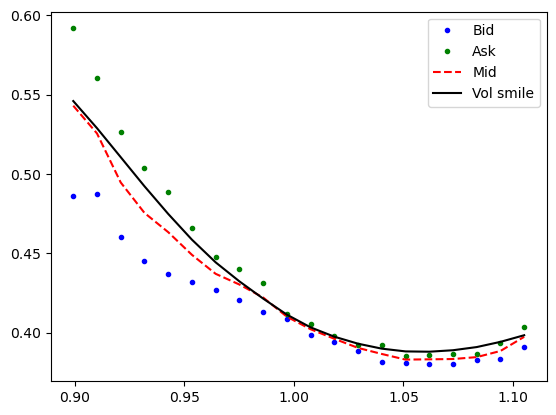

In [103]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/252
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(c,K,T_,r,S0)), 'k', label='Vol smile')
plt.legend()
plt.show()

## Other maturities

In [104]:
def G1_(V,u_list,h_list,K,omega,S0,delta_t,P1,P1_disc_X1):
    Iu = I_u_(h_list,V,K,S0,50,120,delta_t,P1)
    expectation = np.sum(Iu*np.exp(-u_list)*P1_disc_X1)
    return np.sum(u_list*P1_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1_(V,u_list,h_list,K,omega,S0,delta_t,P1,P1_disc_X1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - np.sum(I_Q_(h_list,V,K,Q,S0,50,120,delta_t,P1)*np.exp(-u_list)*P1_disc_X1) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/2784386253.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


ValueError: operands could not be broadcast together with shapes (20,) (11,) 

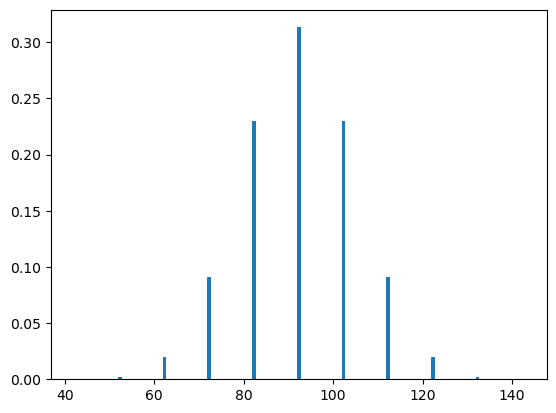

In [107]:
maturities = amd_calls.index.unique()

a, b, n = S0-50, S0+50, 11 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid
T1 = maturities[0] #TODO: convert to integers

t0 = date(2023, 4, 8)
t1 = maturities[0].to_pydatetime().date()
delta = t1 - t0
delta = delta.days
P1_ = lambda s1: norm.pdf(s1, S0, calculate_sigma0(S0,delta)*np.sqrt(delta)) # Marginal distribution of S at t1
P1_disc = lambda x: P1_(x)/sum(P1_(X1))
xx = np.linspace(0,200,1000)
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc(X1))


u_list, h_list = np.zeros(n), np.zeros(n)
print(G1_(V,u_list,h_list,K,omega_K,X1,delta_t,P1_,P1_disc(X1)))
print(grad_G1_(V,u_list,h_list,K,omega_K,X1,delta_t,P1_,P1_disc(X1)))

In [106]:
for T1 in maturities[1:2]:
    C1 = amd_calls.loc[T1]
    C1 = C1.reset_index(drop=True)
    
    r = 0.01 # TODO: figure out r
    ask = np.array(C1['Ask'])
    bid = np.array(C1['Bid'])
    mid = np.array(C1['Mid'])
    K = np.array(C1['Strike'])
    
    u_list = np.zeros(n)
    h_list = np.zeros(n)
    
    while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
        for i in range(n): 
            s1 = X1[i]
            V_prev = V
            h0 = optimize.root_scalar(I_h_0_,args=(V,K,s1,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
            h_list[i] = h0
            u0 = np.log(I_u_(h0,V,K,s1,50,120,delta_t,P1))
            u_list[i] = u[0]

        print(f'h_list = {h_list}')
        print(f'u_list = {u_list}')
        #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
        V = optimize.minimize(fun= G1_, x0=V, args=(u_list,h_list,K,omega_K,s1,delta_t,P1_,P1_disc(X1)), method='Newton-CG', jac= grad_G1_, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
        print(f'V = {V}')

        print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
        print("----------")

    
    
    
    # Compute next marginal probability (S at t2)
    P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
    P1_disc = lambda x: P1(x)/sum(P1(X1))
    #sum(P1_disc(X1)) = 1